Build a star library?
Add our pre-redered star to the complete disperion image

In [13]:
# General imports
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
from astropy.io import fits
from astropy.table import Table
import os
os.chdir("/Users/keith/astr/research_astr/roman_grism_sim/ultra_smooth_lambda_dependent/fits")

# Pretty plots
import matplotlib
matplotlib.rcParams["figure.figsize"] = (11,8.5)
matplotlib.rcParams["image.interpolation"] = "nearest"
matplotlib.rcParams["image.origin"] = "lower"

# Grizli
from grizli.model import GrismFLT

# pysynphot
import pysynphot as S

# WebbPSF
import webbpsf
import webbpsf.roman

In [14]:
wfi = webbpsf.roman.WFI()
# webbpsf.setup_logging("Error")

spec = Table.read("/Users/keith/astr/research_astr/FOV0/FOV0_SEDs/ukg0v.dat", format="ascii")
src = S.ArraySpectrum(wave=spec["col1"], flux=spec["col2"])

In [15]:
psf_collector = []

bins = 3

for ii, lam in enumerate(np.linspace(10000, 20000, bins+1)):
    if lam == 20000:
        break
    psf_collector.append(wfi.calc_psf(monochromatic=(lam * (10**-10)), fov_pixels=182, oversample=2, source=src)[0].data)

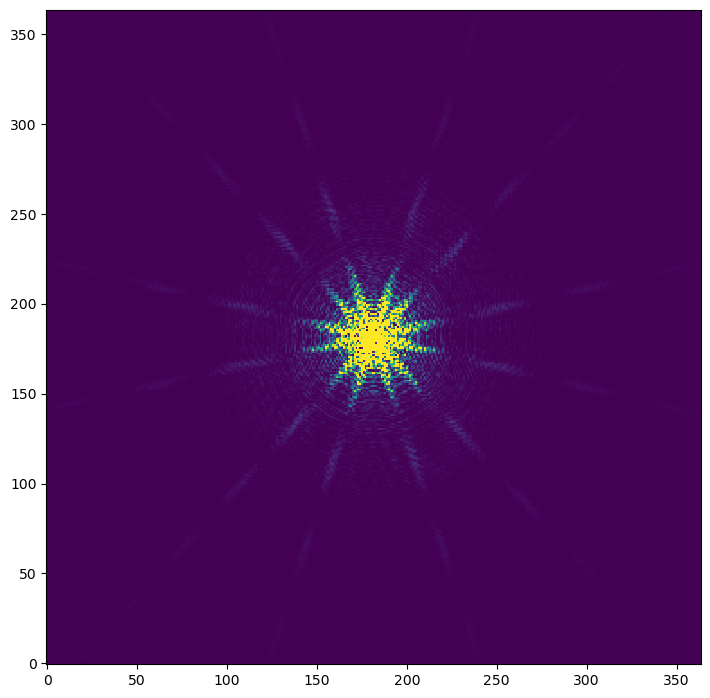

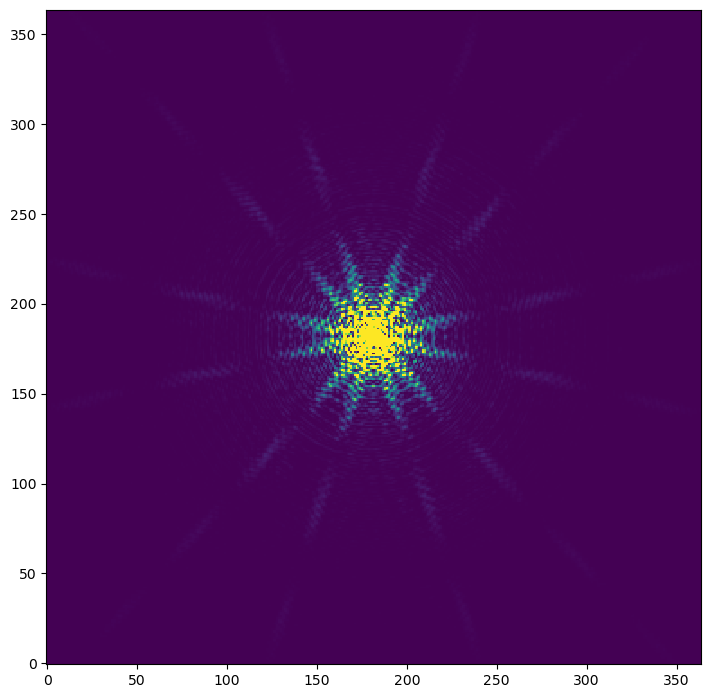

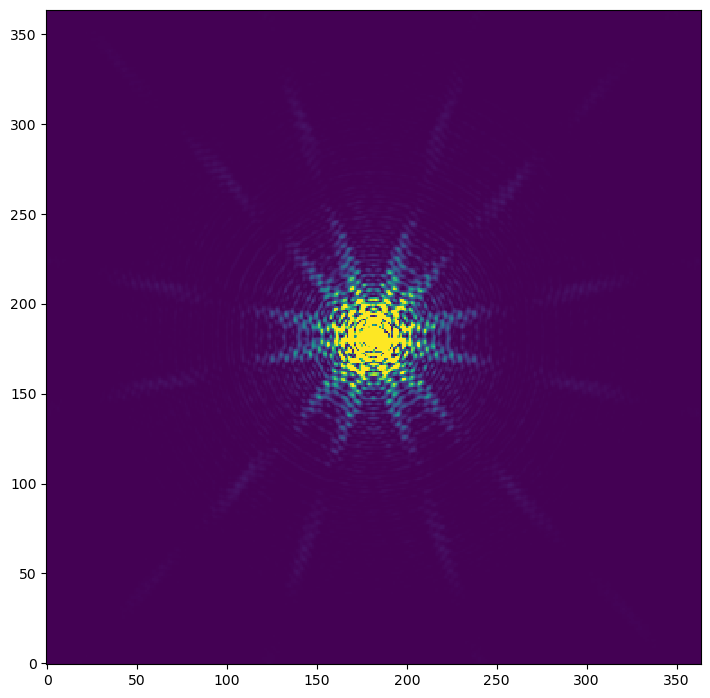

In [16]:
for ii in psf_collector:
    plt.imshow(ii, vmin=0, vmax=0.00005)
    plt.show()

In [17]:
pad = 200
roman = GrismFLT(direct_file="empty_direct.fits", seg_file="empty_seg.fits", pad=pad)

Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
empty_direct.fits / Pad ref HDU with 464 pixels
empty_direct.fits / blot segmentation empty_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


In [18]:
psf_direct = np.zeros((4288, 4288))
psf_direct[(2144-182): (2144+182), (2144-182):(2144+182)] = psf_collector[0]

roman.direct.data["SCI"] = psf_direct.astype("float32")
roman.seg = np.where(roman.direct.data["SCI"], 1, 0).astype("float32")

In [19]:
spec = Table.read("/Users/keith/astr/research_astr/FOV0/FOV0_SEDs/ukg0v.dat", format="ascii")
wave = spec["col1"]
flux = spec["col2"]

In [20]:
window_extent = 4
half_extent = int(window_extent / 2)

window_wave = np.linspace(-np.pi / 2, np.pi / 2, window_extent)
window_flux = np.cos(window_wave)

In [21]:
begin_index = 1570
end_index = 2170

chunk_1_wave = wave[begin_index:end_index]
front_wave = window_wave[0:half_extent] + chunk_1_wave[0]
back_wave = np.flip(chunk_1_wave[-1] + window_wave[half_extent:])

chunk_1_flux = flux[begin_index:end_index]
front = window_flux[0:half_extent] * chunk_1_flux[0]
back = window_flux[half_extent:] * chunk_1_flux[-1]

chunk_1_wave = np.append(front_wave, np.append(chunk_1_wave, back_wave))
chunk_1_flux = np.append(front, np.append(chunk_1_flux, back))
chunk_1 = [chunk_1_wave, chunk_1_flux]

begin_index = 2169
end_index = 2770

chunk_2_wave = wave[begin_index:end_index]
front_wave = window_wave[0:half_extent] + chunk_2_wave[0]
back_wave = np.flip(chunk_2_wave[-1] + window_wave[half_extent:])

chunk_2_flux = flux[begin_index:end_index]
front = window_flux[0:half_extent] * chunk_2_flux[0]
back = window_flux[half_extent:] * chunk_2_flux[-1]

chunk_2_wave = np.append(front_wave, np.append(chunk_2_wave, back_wave))
chunk_2_flux = np.append(front, np.append(chunk_2_flux, back))
chunk_2 = [chunk_2_wave, chunk_2_flux]

flat_spec = [wave[begin_index:end_index],
                np.asarray([1.0 for ii in wave])]

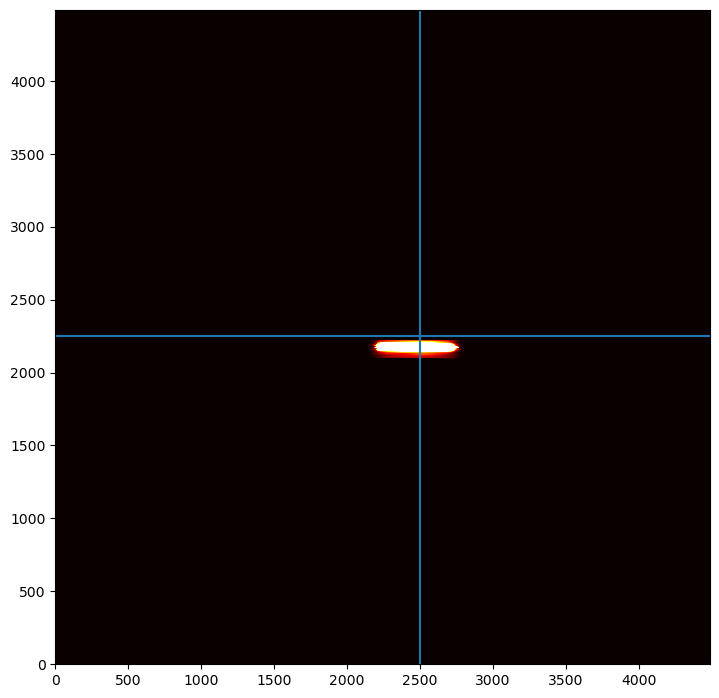

In [22]:
chunk_model_1 = roman.compute_model_orders(id=1, mag=1, compute_size=False, size=77, 
                                           in_place=False, store=False, is_cgs=True, 
                                           spectrum_1d=chunk_1)[1]

chunk_model_2 = roman.compute_model_orders(id=1, mag=1, compute_size=False, size=77,
                                           in_place=False, store=False, is_cgs=True,
                                           spectrum_1d=chunk_2)[1]

flat_model = roman.compute_model_orders(id=1, mag=1, compute_size=False, size=77,
                                          in_place=False, store=False, is_cgs=True,
                                          spectrum_1d=flat_spec)[1]

full_model = roman.compute_model_orders(id=1, mag=1, compute_size=False, size=77,
                                        in_place=False, store=False, is_cgs=True,
                                        spectrum_1d=[wave, flux])[1]

chunk_model = chunk_model_1 + chunk_model_2

plt.imshow(chunk_model, vmin=0, vmax=chunk_model.max()/1000, cmap="hot")
plt.axhline(2250)
plt.axvline(2500)

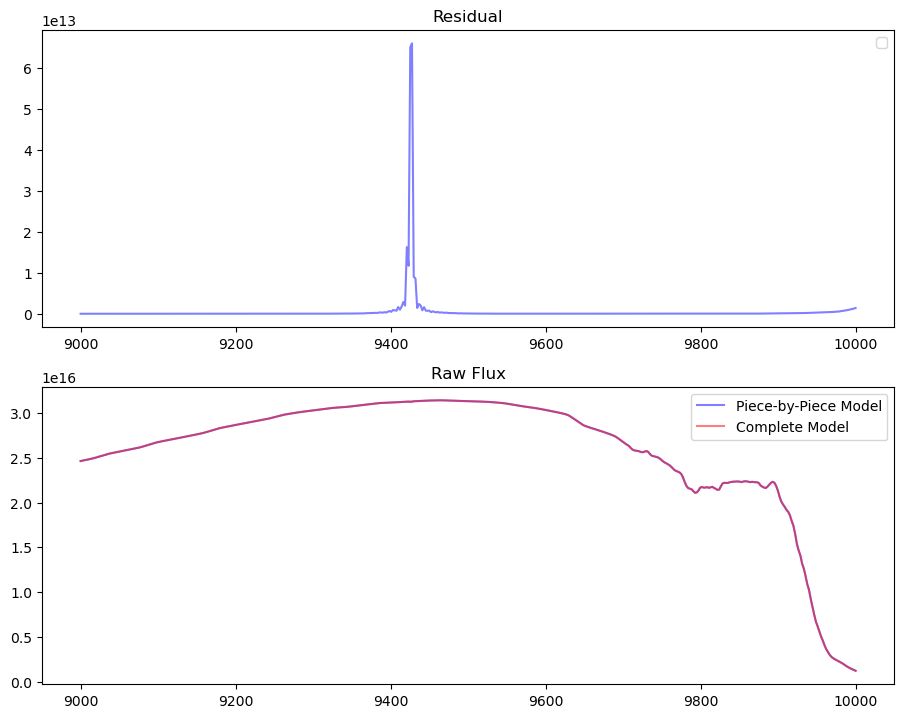

In [23]:
chunk_cutout = chunk_model[2050:2250, 2300:2750]
full_cutout = full_model[2050:2250, 2300:2750]
flat_cutout = flat_model[2050:2250, 2300:2750]

chunk_flux = np.asarray([chunk_cutout[:, ii].sum() for ii in range(chunk_cutout.shape[1])])
full_flux = np.asarray([full_cutout[:, ii].sum() for ii in range(full_cutout.shape[1])])
flat_flux = np.asarray([flat_cutout[:, ii].sum() for ii in range(flat_cutout.shape[1])])
wave = np.linspace(9000, 10000, chunk_cutout.shape[1])

extract_flux = chunk_flux / flat_flux
full_extract = full_flux / flat_flux

fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.set_title("Residual")
ax1.plot(wave, full_flux - chunk_flux, c='b', alpha=0.5, label="")
ax1.legend()

ax2.set_title("Raw Flux")
ax2.plot(wave, chunk_flux, c='b', alpha=0.5, label="Piece-by-Piece Model")
ax2.plot(wave, full_flux, c='r', alpha=0.5, label="Complete Model")
ax2.legend()

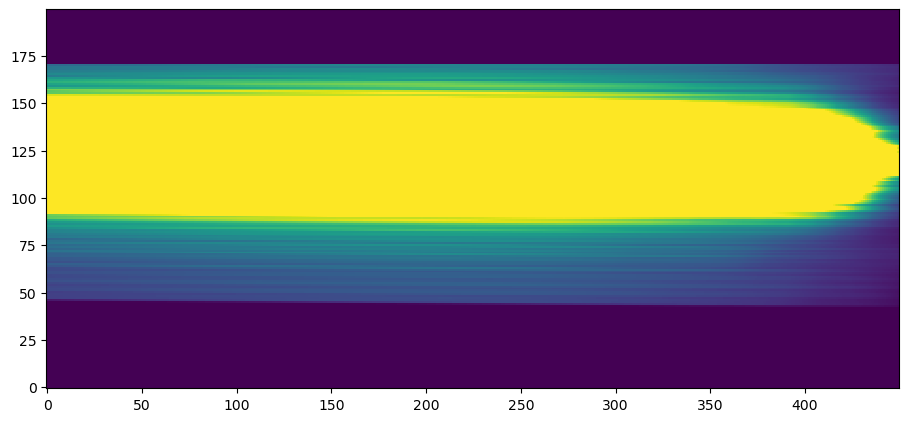

In [24]:
plt.imshow(chunk_cutout, vmin=0, vmax=chunk_cutout.max()/1000)